# Recommender System for ml-100k dataset

## By Lukas Koch Vindbjerg and Malthe Faurschou Tøttrup

In [ ]:
from surprise import SVD, KNNBasic, NMF
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
from surprise import Dataset

plt.rcParams['figure.figsize'] = [20, 4]

# Understanding the dataset

In [2]:
# Load the ml-100k dataset
data = Dataset.load_builtin('ml-100k')

# Build a dataframe from the dataset
ratings = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
ratings = ratings.drop('timestamp', axis=1)
# Print the first 5 datapoints
ratings.head(5)

,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


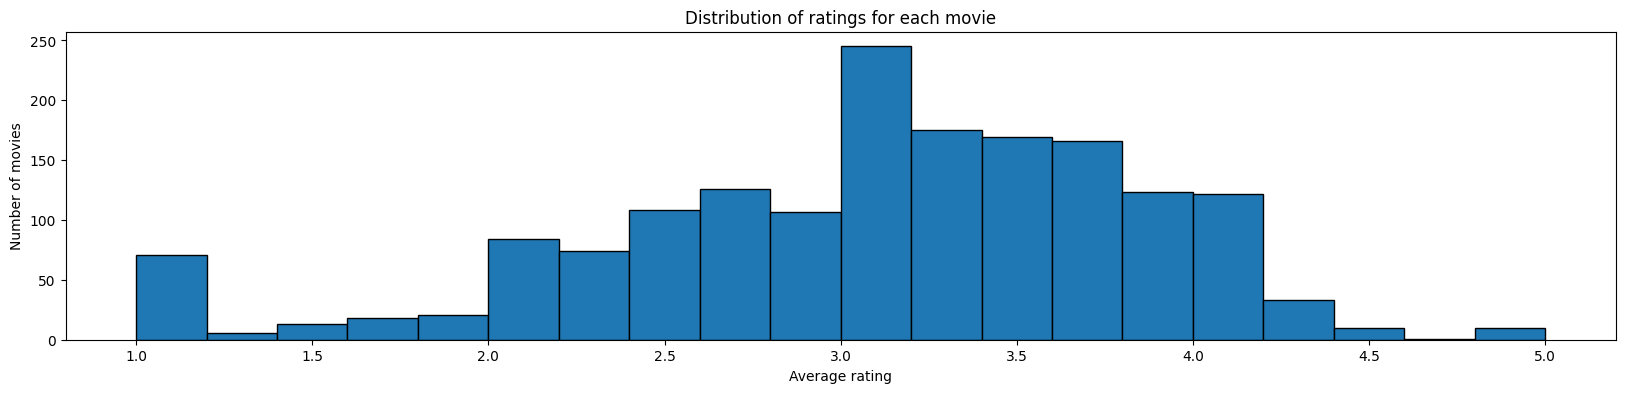

In [3]:
# Group the ratings by movie
movie_ratings = ratings.groupby('item_id')['rating'].agg(['count', 'mean'])

# Plot the distribution of ratings for each movie
fig, ax = plt.subplots()
ax.hist(movie_ratings['mean'], bins=20, range=(1, 5), edgecolor='black')
ax.set_xlabel('Average rating')
ax.set_ylabel('Number of movies')
ax.set_title('Distribution of ratings for each movie')
plt.show()

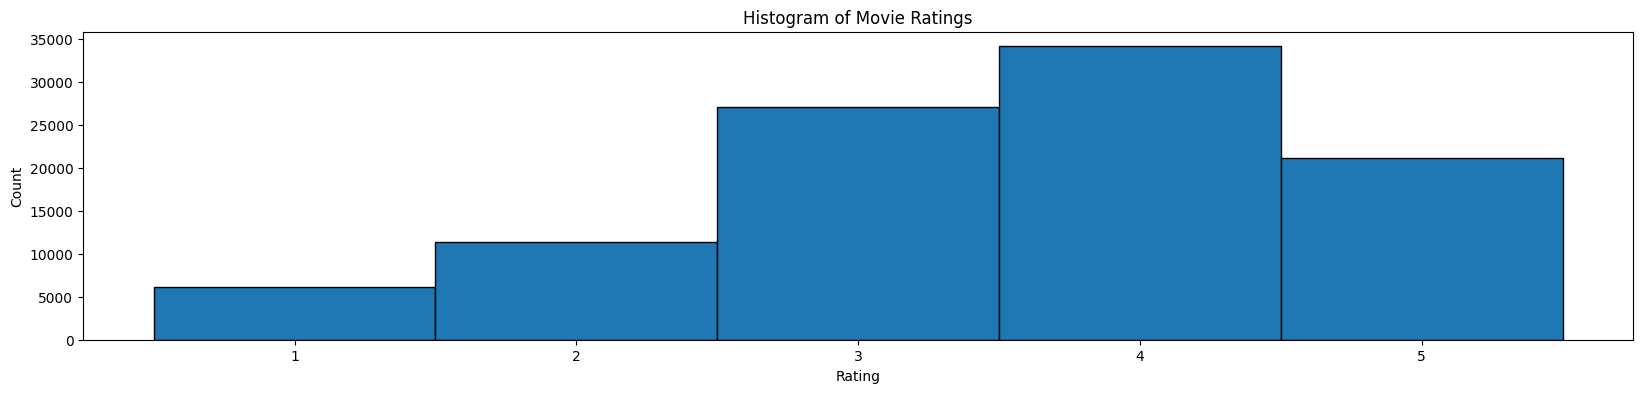

In [4]:
# Create a histogram of the ratings
plt.hist(ratings['rating'], bins=5, range=(1, 6), edgecolor='black', align='left')

# Set the title and axis labels
plt.title('Histogram of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Set the x-axis tick locations and labels
plt.xticks(range(1, 6), range(1, 6))


# Show the plot
plt.show()


In [5]:
# calculate the average rating for each movie
movie_ratings = ratings.groupby('item_id')['rating'].agg(['count', 'mean'])
movie_ratings

,count,mean
item_id,,
1,452,3.878319
10,89,3.831461
100,508,4.155512
1000,10,3.000000
1001,17,2.000000
...,...,...
995,31,3.161290
996,14,2.500000
997,16,2.125000


In [6]:
trainset, testset = train_test_split(data, test_size=0.25)

# calculate the average rating for each movie in the training set and test set
trainset_mean = trainset.global_mean

testset_mean = 0
for i in range(len(testset)):
    testset_mean += testset[i][2]

testset_mean = testset_mean / len(testset)
print(testset_mean, trainset_mean)

3.53256 3.52896


# Decide the best algorithm for the dataset

In [7]:
# Define the evaluation metric (in this case, RMSE)
sim_options = {'name': 'cosine', 'user_based': True}

# Define the algorithms to compare
algorithms = [SVD(), KNNBasic(sim_options=sim_options), NMF()]

# Evaluate the algorithms using cross-validation
for algorithm in algorithms:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    print(f"{algorithm.__class__.__name__}: Average RMSE = {sum(results['test_rmse'])/len(results['test_rmse'])}")

# Lowest RMSE is for SVD

SVD: Average RMSE = 0.9367734586944246
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNBasic: Average RMSE = 1.0168915784658759
NMF: Average RMSE = 0.9649762464928411


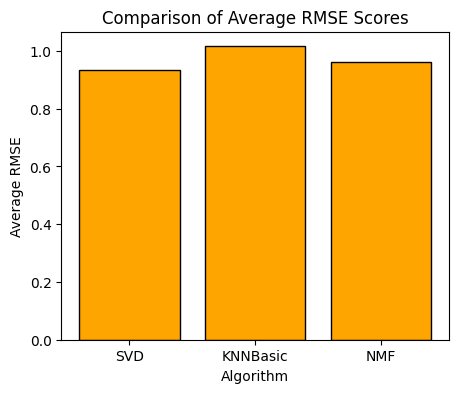

In [22]:
# Set the data for the bar chart
algorithms = ['SVD', 'KNNBasic', 'NMF']
rmse_scores = [0.935738685855846, 1.015940633654907, 0.9635159047693793]

# Create the bar chart
fig, ax = plt.subplots()
ax.bar(algorithms, rmse_scores, color='orange', edgecolor='black')

# Set the title and axis labels
ax.set_title('Comparison of Average RMSE Scores')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Average RMSE')

# Display the plot
plt.rcParams['figure.figsize'] = [5, 4]
plt.show()

# Grid search for the best SVD parameters

In [9]:
# Define the parameter grid for the SVD algorithm
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008], 'reg_all': [0.08, 0.1, 0.15]}

# Define the grid search object and fit it on the dataset
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# Print the best RMSE and MAE scores, along with the corresponding hyperparameters
print(f"Best RMSE score: {gs.best_score['rmse']:.3f}")
print(f"Best MAE score: {gs.best_score['mae']:.3f}")
print(f"Best hyperparameters: {gs.best_params['rmse']}")


Best RMSE score: 0.919
Best MAE score: 0.726
Best hyperparameters: {'n_factors': 40, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


In [10]:
factors = gs.best_params['rmse']['n_factors']
epochs = gs.best_params['rmse']['n_epochs']
lr_value = gs.best_params['rmse']['lr_all']
reg_value = gs.best_params['rmse']['reg_all']

# Fit the best model to the training set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

In [11]:
# Test the model on the test set

# Generate predictions for the testing set
predictions = algo.test(testset)

# Calculate and print the RMSE and MAE of the predictions
print(f"RMSE: {accuracy.rmse(predictions)}")
print(f"MAE: {accuracy.mae(predictions)}")

RMSE: 0.9175
RMSE: 0.9175240893752575
MAE:  0.7278
MAE: 0.7277610938836608


In [12]:
def get_num_user_ratings(uid):
    """ 
    args: 
      uid: user id
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_num_item_ratings(iid):
    """ 
    args:
      iid: the item id
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_num_user_ratings)
df_predictions['Ui'] = df_predictions.iid.apply(get_num_item_ratings)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,757,175,3.0,3.762307,{'was_impossible': False},137,159,0.762307
1,330,1044,5.0,4.104754,{'was_impossible': False},119,29,0.895246
2,347,177,5.0,3.890388,{'was_impossible': False},140,101,1.109612
3,882,177,5.0,4.339464,{'was_impossible': False},99,101,0.660536
4,872,354,4.0,3.508827,{'was_impossible': False},53,57,0.491173


In [13]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [14]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
15553,862,64,5.0,5.0,{'was_impossible': False},127,215,0.0
20327,928,487,5.0,5.0,{'was_impossible': False},26,53,0.0
16407,617,424,1.0,1.0,{'was_impossible': False},79,13,0.0
22000,405,1246,1.0,1.0,{'was_impossible': False},550,4,0.0
10901,405,1274,1.0,1.0,{'was_impossible': False},550,9,0.0
23324,513,50,5.0,5.0,{'was_impossible': False},13,417,0.0
4740,907,96,5.0,5.0,{'was_impossible': False},104,217,0.0
14841,372,98,5.0,5.0,{'was_impossible': False},47,290,0.0
11602,907,633,5.0,5.0,{'was_impossible': False},104,45,0.0
5366,507,316,5.0,5.0,{'was_impossible': False},47,85,0.0


In [15]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
17683,127,750,1.0,4.342411,{'was_impossible': False},17,96,3.342411
12524,503,156,1.0,4.345766,{'was_impossible': False},116,112,3.345766
875,186,12,1.0,4.378585,{'was_impossible': False},62,205,3.378585
8340,270,237,1.0,4.399968,{'was_impossible': False},100,293,3.399968
7770,312,265,1.0,4.404663,{'was_impossible': False},171,175,3.404663
8973,567,100,1.0,4.414231,{'was_impossible': False},113,367,3.414231
9556,405,452,5.0,1.546352,{'was_impossible': False},550,53,3.453648
3720,534,93,1.0,4.465854,{'was_impossible': False},60,82,3.465854
363,405,376,5.0,1.465169,{'was_impossible': False},550,16,3.534831
9395,620,100,1.0,4.548844,{'was_impossible': False},80,367,3.548844


In [16]:
print(predictions[0])

user: 757        item: 175        r_ui = 3.00   est = 3.76   {'was_impossible': False}


# Precision and recall


In [17]:
# ref: https://surprise.readthedocs.io/en/stable/FAQ.html

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results

[{'K': 2, 'Precision': 0.9411452810180275, 'Recall': 0.1893198002545543},
 {'K': 3, 'Precision': 0.9326617179215249, 'Recall': 0.2728747385997079},
 {'K': 4, 'Precision': 0.9259455638034638, 'Recall': 0.34874124993238775},
 {'K': 5, 'Precision': 0.9216507599858589, 'Recall': 0.4145692436490554},
 {'K': 6, 'Precision': 0.9183280311063984, 'Recall': 0.47169163995942837},
 {'K': 7, 'Precision': 0.9146164722516781, 'Recall': 0.5199504019539876},
 {'K': 8, 'Precision': 0.9087650860980658, 'Recall': 0.5588581197068523},
 {'K': 9, 'Precision': 0.9044496625090506, 'Recall': 0.593157888727049},
 {'K': 10, 'Precision': 0.9015157636048395, 'Recall': 0.623810846367314}]

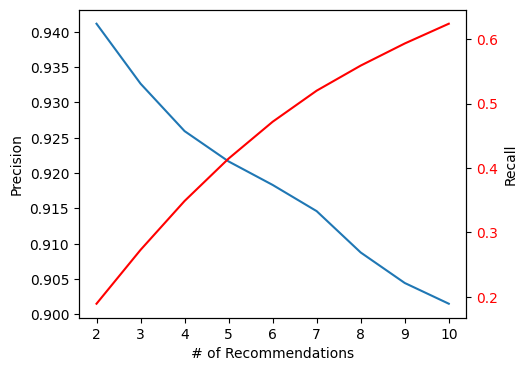

In [18]:
plt.rcParams['figure.figsize'] = [5, 4]

Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')
    ###




# Recommend movies!

In [19]:
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

In [20]:
# Load the dataset into a Pandas dataframe
df = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# Filter the dataframe to only include ratings for user 10
user_10_ratings = df.loc[df['user_id'] == 10]

# Group the ratings by movie ID and calculate the mean rating for each movie
mean_ratings = user_10_ratings.groupby('movie_id')['rating'].mean()

# Sort the mean ratings in descending order and select the top 5 movies
top_5_movies = mean_ratings.sort_values(ascending=False)[:5]

# Get movie_id for the top 5 movies
top_5_movie_ids = top_5_movies.index

# Load the movies dataset into a Pandas dataframe
movies_df = pd.read_csv("ml-100k/u.item", encoding='latin-1', sep="|", names = ["movie_id", "title", "release", "None", "url", "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"])

top_5 = pd.DataFrame()

for i in range (len(top_5_movie_ids)):
    movie = movies_df.loc[movies_df['movie_id'] == top_5_movie_ids.to_numpy()[i]]
    # Drop columns where all the values are 0
    movie = movie.loc[:, (movie != 0).any(axis=0)]
    top_5 = pd.concat([top_5, movie])

top_5

,movie_id,title,release,None,url,Drama,Sci-Fi,Romance,Mystery,Horror,Thriller
356,357,One Flew Over the Cuckoo's Nest (1975),01-Jan-1975,NaN,http://us.imdb.com/M/title-exact?One%20Flew%20...,1.0,NaN,NaN,NaN,NaN,NaN
178,179,"Clockwork Orange, A (1971)",01-Jan-1971,NaN,http://us.imdb.com/M/title-exact?Clockwork%20O...,NaN,1.0,NaN,NaN,NaN,NaN
530,531,Shine (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Shine%20(1996),1.0,NaN,1.0,NaN,NaN,NaN
190,191,Amadeus (1984),01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Amadeus%20(1984),1.0,NaN,NaN,1.0,NaN,NaN
184,185,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),NaN,NaN,1.0,NaN,1.0,1.0


In [21]:
# Get the raw user id for user 10
user_id = str(10)

# Extract the predicted ratings for user 10
user_ratings = {}
for uid, iid, true_r, est, _ in predictions:
    if uid == user_id:
        user_ratings[iid] = est

# Sort the items by predicted rating and select the top 5
sorted_ratings = sorted(user_ratings.items(), key=lambda x: x[1], reverse=True)
top_5 = sorted_ratings[:5]

# Print the top 5 recommendations for user 10
top_5_pred = pd.DataFrame()
print(f"Top 5 recommendations for user {user_id}:")
for item in top_5:
    print(f"\t{item[0]} (predicted rating: {item[1]:.2f})")
    movie = movies_df.loc[movies_df['movie_id'] == int(item[0])]
    # Drop columns where all the values are 0
    movie = movie.loc[:, (movie != 0).any(axis=0)]
    top_5_pred = pd.concat([top_5_pred,movie])


top_5_pred

Top 5 recommendations for user 10:
	1449 (predicted rating: 4.92)
	318 (predicted rating: 4.90)
	408 (predicted rating: 4.82)
	169 (predicted rating: 4.77)
	114 (predicted rating: 4.71)


,movie_id,title,release,None,url,Drama,War,Animation,Comedy,Thriller
1448,1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,1.0,NaN,NaN,NaN,NaN
317,318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,1.0,1.0,NaN,NaN,NaN
407,408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,NaN,NaN,1.0,1.0,1.0
168,169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,NaN,NaN,1.0,1.0,NaN
113,114,Wallace & Gromit: The Best of Aardman Animatio...,05-Apr-1996,NaN,http://us.imdb.com/Title?Wallace+%26+Gromit%3A...,NaN,NaN,1.0,NaN,NaN
